Classifying Flowers using Transfer Learning in Keras

1- Download a small flower dataset (http://download.tensorflow.org/example_images/flower_photos.tgz). This dataset has 5 classes (Daisy, Dandelion, Rese, Sunflower, and Tulip). Images for each class are stored in its own folder.

2- The images have different dimensions. Resize all of them to 150x150.

3- Split images to 75-25% for training and test. Make sure you have the same distribution of flower types between train and test datasets. 

4- Use a VGG16 model (pre-trained on ImageNet)

5- Remove the top layers (fully connected layers)

6- Add your own fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 5 nodes and ‘softmax’ activation)

7- First, freeze all layers of VGG16, train (fine-tune) and evaluate the model. You need to pick the right hyper-parameters for your training (try with different ones)

8- Second, unfreeze the last block of VGG16 (block5), re-train and evaluate the model

9- Unfreeze all the layers and try again. 

10- Compare the accuracy you got in both cases . Which one is better and why? 

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras import applications
import tensorflow as tf
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import random
from shutil import copyfile
import os
import gc
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras import backend as K
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns
from keras.callbacks import ModelCheckpoint
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [3]:
import os
print(os.listdir('../input/flower_photos/flower_photos'))

['tulips', 'sunflowers', 'roses', 'dandelion', 'daisy']


In [4]:
X=[]
y=[]
IMG_SIZE=150
DAISY_DIR='../input/flower_photos/flower_photos/daisy'
SUNFLOWER_DIR='../input/flower_photos/flower_photos/sunflowers'
TULIP_DIR='../input/flower_photos/flower_photos/tulips'
DANDI_DIR='../input/flower_photos/flower_photos/dandelion'
ROSE_DIR='../input/flower_photos/flower_photos/roses'


In [5]:
def assigning_label(img,flower_type):
    return flower_type

In [6]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assigning_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        y.append(str(label))

In [7]:
#create training data
make_train_data('Daisy',DAISY_DIR)
make_train_data('Sunflowers',SUNFLOWER_DIR)
make_train_data('Tulips',TULIP_DIR)
make_train_data('dandelion',DANDI_DIR)
make_train_data('Roses',ROSE_DIR)
print(len(X))

100%|██████████| 641/641 [00:02<00:00, 278.26it/s]

3670


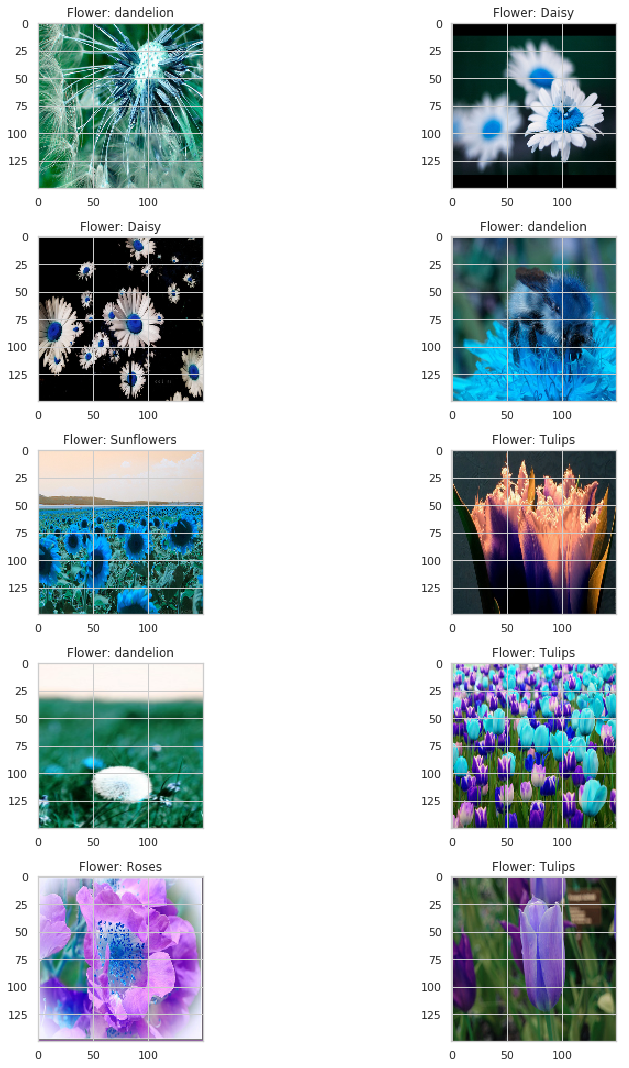

In [8]:
import random as rn
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+y[l])
        
plt.tight_layout()

In [9]:
from sklearn.preprocessing import LabelEncoder

labelEncoder=LabelEncoder()
y=labelEncoder.fit_transform(y)
y=to_categorical(y,5)
X=np.array(X)
X=X/255

In [10]:
X.shape

(3670, 150, 150, 3)

In [11]:
y.shape

(3670, 5)

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=123)
#for train_index, test_index in split.split(X,y):
#    X_train = X[train_index]
#    X_test = X[test_index]
#    y_train = y[train_index]
#    y_test = y[test_index]

In [13]:
X_train.shape

(2752, 150, 150, 3)

In [14]:
y_train.shape

(2752, 5)

In [15]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
image_w, image_h = 150,150
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))

58892288/58889256 [==============================] - 6s 0us/step


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Model 1 - VGG16  imorted with top layers cut off, all layers then are frozen and new fully connected layers are added.

In [17]:
for layer in model.layers:
    layer.trainable = False
    
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [18]:
def Revised_1_fn(learn_rate=0.001): 
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_1 = Model(model.input, preds)
    Revised_Model_1.summary()
    Revised_Model_1.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_1

Model 2 -  Second, unfreeze the last block of VGG16 (block5)

In [19]:
for layer in model.layers[15:]:
    layer.trainable = True
     
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [20]:
def Revised_2_fn(learn_rate=0.001):
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_2 = Model(model.input, preds)
    Revised_Model_2.summary()
    Revised_Model_2.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_2

Model 3 : Unfreeze all the layers 

In [21]:
for layer in model.layers:
    layer.trainable = True
     
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [22]:
def Revised_3_fn(learn_rate=0.001): 
    last = model.output
    x = Flatten()(last)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    preds = Dense(5, activation='softmax')(x)

    Revised_Model_3 = Model(model.input, preds)
    Revised_Model_3.summary()
    Revised_Model_3.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return Revised_Model_3

Train, Fine-Tune using Hyper parameters and evaluate the first model.

In [23]:
#using Grid Search and Early stopping
es = EarlyStopping(monitor='acc', verbose=2, patience=25)
mc = ModelCheckpoint('./best_model_1.h5', monitor='acc', verbose=2, save_best_only=True)

Hyp_Model_1 = KerasClassifier(build_fn=Revised_1_fn)
#You need to pick the right hyper-parameters for your training (try with different ones)

learn_rate = [0.001,0.01]
batch_size = [32]
epochs = [5]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate = learn_rate)
gridsearch_1 = GridSearchCV(estimator = Hyp_Model_1, param_grid=param_grid, cv=5)

In [24]:
new_grid_1 = gridsearch_1.fit(X_train,y_train, verbose=2,callbacks=[es,mc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

2202/2202 [==============================] - 11s 5ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPo

Epoch 1/5
 - 33s - loss: 0.5672 - acc: 0.7905

Epoch 00001: acc did not improve from 0.85325
Epoch 2/5
 - 30s - loss: 0.3814 - acc: 0.8678

Epoch 00002: acc improved from 0.85325 to 0.86779, saving model to ./best_model_1.h5
Epoch 3/5
 - 30s - loss: 0.4290 - acc: 0.8492

Epoch 00003: acc did not improve from 0.86779
Epoch 4/5
 - 30s - loss: 0.3002 - acc: 0.8919

Epoch 00004: acc improved from 0.86779 to 0.89187, saving model to ./best_model_1.h5
Epoch 5/5
 - 30s - loss: 0.2719 - acc: 0.9114

Epoch 00005: acc improved from 0.89187 to 0.91140, saving model to ./best_model_1.h5
2201/2201 [==============================] - 11s 5ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
______________________________

 - 30s - loss: 0.2849 - acc: 0.9019

Epoch 00002: acc did not improve from 0.91644
Epoch 3/5
 - 30s - loss: 0.2763 - acc: 0.9096

Epoch 00003: acc did not improve from 0.91644
Epoch 4/5
 - 30s - loss: 0.3070 - acc: 0.8978

Epoch 00004: acc did not improve from 0.91644
Epoch 5/5
 - 30s - loss: 0.2185 - acc: 0.9278

Epoch 00005: acc improved from 0.91644 to 0.92779, saving model to ./best_model_1.h5
2202/2202 [==============================] - 11s 5ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (

 - 38s - loss: 0.2055 - acc: 0.9331

Epoch 00004: acc did not improve from 0.95095
Epoch 5/5
 - 38s - loss: 0.1698 - acc: 0.9455

Epoch 00005: acc did not improve from 0.95095


In [25]:
#from sklearn.metrics import accuracy_score
print(new_grid_1.best_params_)
print(new_grid_1.best_estimator_)
print(new_grid_1.best_score_)

{'batch_size': 32, 'epochs': 5, 'learn_rate': 0.01}
0.8499273256896887


In [26]:
from keras.models import load_model
final_model_1 = load_model('./best_model_1.h5')

In [27]:
# evaluate the model
cvscores = []
finalscores = []
final_scores_1 = final_model_1.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (final_model_1.metrics_names[1], final_scores_1[1]*100))
cvscores.append(new_grid_1.best_score_*100)
finalscores.append(final_scores_1[1] * 100)

acc: 74.07%


In [28]:
import gc
gc.collect()

4

Train, Fine-Tune using Hyper parameters and evaluate the second model.

In [29]:
#using Grid Search and Early stopping
es = EarlyStopping(monitor='acc', verbose=2, patience=5)
mc = ModelCheckpoint('./best_model_2.h5', monitor='acc', verbose=2, save_best_only=True)

Hyp_Model_2 = KerasClassifier(build_fn=Revised_2_fn)
#You need to pick the right hyper-parameters for your training (try with different ones)

learn_rate = [0.001,0.01]
batch_size = [32]
epochs = [5]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate = learn_rate)
gridsearch_2 = GridSearchCV(estimator = Hyp_Model_2, param_grid=param_grid, cv=5)

In [30]:
new_grid_2 = gridsearch_2.fit(X_train,y_train, verbose=2,callbacks=[es,mc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Epoch 1/5
 - 34s - loss: 0.3529 - acc: 0.8787

Epoch 00001: acc did not improve from 0.96047
Epoch 2/5
 - 30s - loss: 0.1920 - acc: 0.9410

Epoch 00002: acc did not improve from 0.96047
Epoch 3/5
 - 30s - loss: 0.2661 - acc: 0.9164

Epoch 00003: acc did not improve from 0.96047
Epoch 4/5
 - 30s - loss: 0.1947 - acc: 0.9342

Epoch 00004: acc did not improve from 0.96047
Epoch 5/5
 - 30s - loss: 0.1628 - acc: 0.9514

Epoch 00005: acc did not improve from 0.96047
2202/2202 [==============================] - 11s 5ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_______________

 - 30s - loss: 0.1047 - acc: 0.9746

Epoch 00004: acc improved from 0.96047 to 0.97457, saving model to ./best_model_2.h5
Epoch 5/5
 - 30s - loss: 0.2037 - acc: 0.9423

Epoch 00005: acc did not improve from 0.97457
2202/2202 [==============================] - 11s 5ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_

Epoch 1/5
 - 36s - loss: 0.3139 - acc: 0.9151

Epoch 00001: acc did not improve from 0.98865
Epoch 2/5
 - 30s - loss: 0.2200 - acc: 0.9391

Epoch 00002: acc did not improve from 0.98865
Epoch 3/5
 - 30s - loss: 0.0996 - acc: 0.9746

Epoch 00003: acc did not improve from 0.98865
Epoch 4/5
 - 30s - loss: 0.1390 - acc: 0.9678

Epoch 00004: acc did not improve from 0.98865
Epoch 5/5
 - 30s - loss: 0.1658 - acc: 0.9487

Epoch 00005: acc did not improve from 0.98865
2202/2202 [==============================] - 11s 5ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_______________

In [31]:
#from sklearn.metrics import accuracy_score
print(new_grid_2.best_params_)
print(new_grid_2.best_estimator_)
print(new_grid_2.best_score_)

{'batch_size': 32, 'epochs': 5, 'learn_rate': 0.01}
0.9375000000433173


In [32]:
from keras.models import load_model
final_model_2 = load_model('./best_model_2.h5')

In [33]:
# evaluate the model
final_scores_2 = final_model_2.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (final_model_2.metrics_names[1], final_scores_2[1]*100))
cvscores.append(new_grid_2.best_score_*100)
finalscores.append(final_scores_2[1] * 100)

acc: 78.32%


In [34]:
import gc
gc.collect()

526

Train, Fine-Tune using Hyper parameters and evaluate the third model.

In [35]:
#using Grid Search and Early stopping

es = EarlyStopping(monitor='acc', verbose=2, patience=5)
mc = ModelCheckpoint('./best_model_3.h5', monitor='acc', verbose=2, save_best_only=True)

Hyp_Model_3 = KerasClassifier(build_fn=Revised_3_fn)
#You need to pick the right hyper-parameters for your training (try with different ones)

learn_rate = [0.001,0.01]
batch_size = [32]
epochs = [5]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate = learn_rate)
gridsearch_3 = GridSearchCV(estimator = Hyp_Model_3, param_grid=param_grid, cv=5)

In [36]:
new_grid_3 = gridsearch_3.fit(X_train,y_train, verbose=2,callbacks=[es,mc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Epoch 1/5
 - 39s - loss: 0.4293 - acc: 0.8542

Epoch 00001: acc did not improve from 0.98819
Epoch 2/5
 - 30s - loss: 0.1651 - acc: 0.9555

Epoch 00002: acc did not improve from 0.98819
Epoch 3/5
 - 30s - loss: 0.1812 - acc: 0.9487

Epoch 00003: acc did not improve from 0.98819
Epoch 4/5
 - 30s - loss: 0.2272 - acc: 0.9382

Epoch 00004: acc did not improve from 0.98819
Epoch 5/5
 - 30s - loss: 0.1218 - acc: 0.9705

Epoch 00005: acc did not improve from 0.98819
2202/2202 [==============================] - 11s 5ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_______________

 - 30s - loss: 0.2478 - acc: 0.9296

Epoch 00004: acc did not improve from 0.98819
Epoch 5/5
 - 30s - loss: 0.2579 - acc: 0.9496

Epoch 00005: acc did not improve from 0.98819
2202/2202 [==============================] - 11s 5ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
________________________________________

Epoch 1/5
 - 42s - loss: 0.2598 - acc: 0.9296

Epoch 00001: acc did not improve from 0.98819
Epoch 2/5
 - 30s - loss: 0.1443 - acc: 0.9664

Epoch 00002: acc did not improve from 0.98819
Epoch 3/5
 - 30s - loss: 0.1426 - acc: 0.9632

Epoch 00003: acc did not improve from 0.98819
Epoch 4/5
 - 30s - loss: 0.2220 - acc: 0.9469

Epoch 00004: acc did not improve from 0.98819
Epoch 5/5
 - 30s - loss: 0.1249 - acc: 0.9764

Epoch 00005: acc did not improve from 0.98819
2202/2202 [==============================] - 11s 5ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_______________

In [37]:
#from sklearn.metrics import accuracy_score
print(new_grid_3.best_params_)
print(new_grid_3.best_estimator_)
print(new_grid_3.best_score_)

{'batch_size': 32, 'epochs': 5, 'learn_rate': 0.01}
0.9371366278420008


In [38]:
from keras.models import load_model
final_model_3 = load_model('./best_model_3.h5')

In [39]:
# evaluate the model
final_scores_3 = final_model_3.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (final_model_3.metrics_names[1], final_scores_3[1]*100))
cvscores.append(new_grid_3.best_score_*100)
finalscores.append(final_scores_3[1] * 100)

acc: 78.87%


In [40]:
import gc
gc.collect()

655

In [41]:
cvscores

[84.99273256896886, 93.75000000433174, 93.71366278420008]

In [42]:
finalscores

[74.07407400914526, 78.32244013908901, 78.8671023835284]

Text(0.5,1,'Bar Plot of Test Accuracy for all 3 Models')

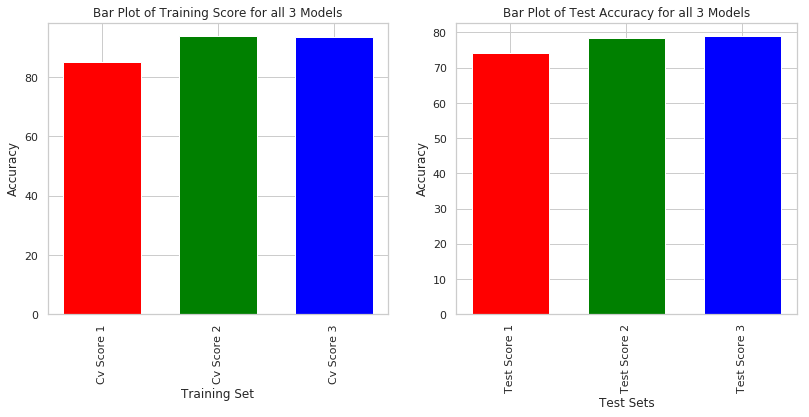

In [43]:
plt.figure(figsize=(25, 5))

plt.subplot(141)
y_hits = cvscores
x_hits = ['Cv Score 1' ,'Cv Score 2' ,'Cv Score 3']
plt.xticks(rotation = 'vertical')
width = 1/1.5
plt.bar(x_hits, y_hits, width, color=['red', 'green', 'blue'])
plt.xlabel('Training Set')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Training Score for all 3 Models')

plt.subplot(142)
y_hits = finalscores
x_hits = ['Test Score 1','Test Score 2','Test Score 3']
plt.xticks(rotation = 'vertical')
width = 1/1.5
plt.bar(x_hits, y_hits, width, color=['red', 'green', 'blue'])
plt.xlabel('Test Sets')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Test Accuracy for all 3 Models')

Based on the graph above, The model with all trainable layers (model 3) is the Best model. Now we predict on Test Data using the best model and Classify the images correctly identified and incorrectly classified

In [44]:
pred=final_model_3.predict(X_test)
pred_digits=np.argmax(pred,axis=1)
act_digits = np.argmax(y_test,axis=1)

In [45]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(act_digits[i]==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not act_digits[i]==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

CORRECTLY CLASSIFIED FLOWER IMAGES

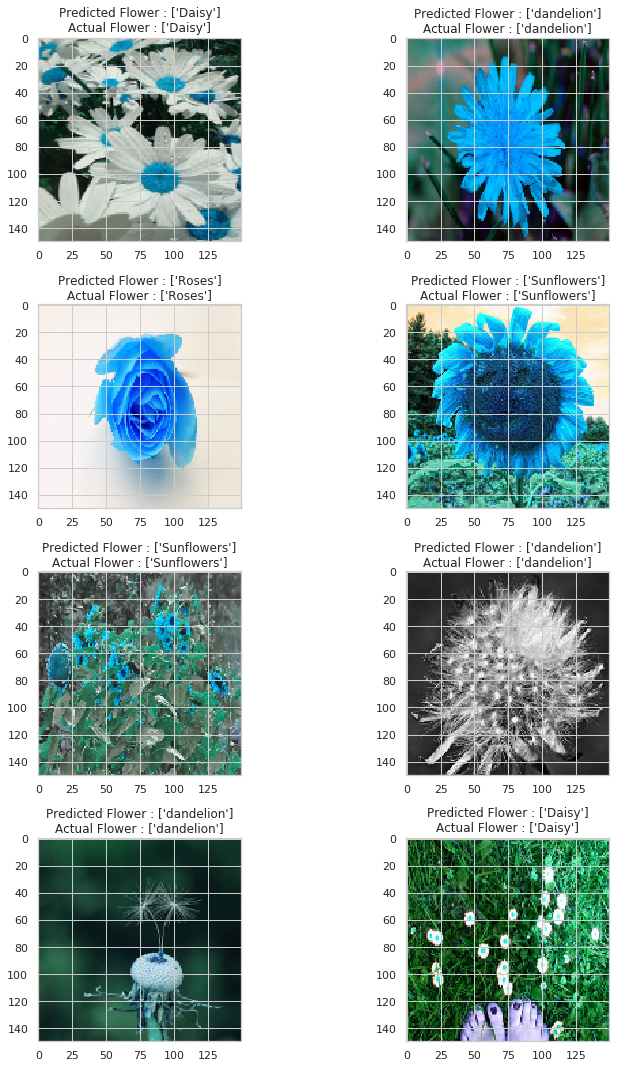

In [46]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(labelEncoder.inverse_transform([pred_digits[prop_class[count]]])) +"\n"+"Actual Flower : "+str(labelEncoder.inverse_transform([act_digits[prop_class[count]]])))
        plt.tight_layout()
        count+=1

MIS CLASSIFIED FLOWER IMAGES

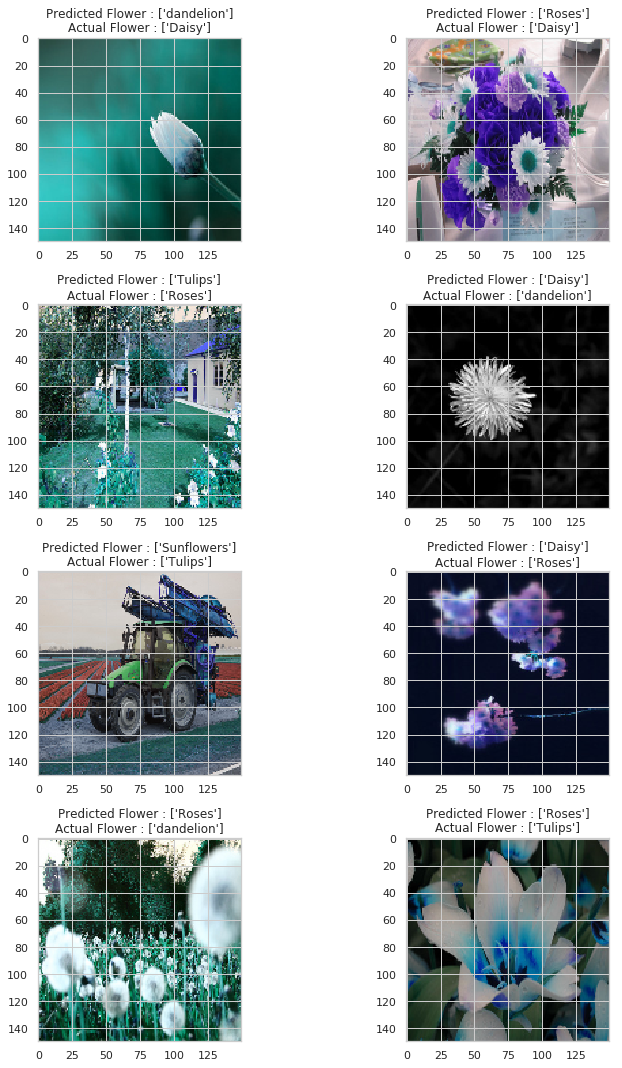

In [47]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(labelEncoder.inverse_transform([pred_digits[mis_class[count]]])) +"\n"+"Actual Flower : "+str(labelEncoder.inverse_transform([act_digits[mis_class[count]]])))
        plt.tight_layout()
        count+=1